# Image tiling

In [1]:
#This is a hack; I have modified a package called "image_bbox_slicer" and here I add the 
#directory containing the modified code to my search path so I can import the modified package.
import sys
# insert at position 1, because 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/john/.../image_bbox_tiler')

In [2]:
from pathlib import Path
from pascal_voc_writer import Writer
from PIL import Image
from torchvision.transforms.functional import pad as tvpad
import random
import pdb
from image_bbox_tiler import image_bbox_slicer as ibs
import re #regex
import subprocess
import pandas as pd
import zipfile
import shutil

## Goal of this notebook
Our ultimate goal is to train an AI model to detect small features (animals) in large images (aerial photographs).  The relatively poor quality of the aerial images means that we can't afford to reduce the image resolution without losing the features we want to detect.  This is generically called a "small-object detection" problem and is an active area of research.  The way the problem is generally handled is to cut large images into smaller 'tiles'.

The images are roughly 6000 x 4000 pixels and we plan to use a tile size of 500 x 500, which means we will have 12 x 8 = 96 tiles per image, i.e., roughly 100 times as many tiles as images.  Even in the training images that contain objects of interest, the objects usually fall in just a few tiles.  For training purposes, there is no benefit to feeding the model vast numbers of empty tiles, but the model may generalize better if _some_ empty tiles are included in the training data.  Tiling images also requires that the corresponding bounding box annotations must be chopped up appropriately (transforming coordinates and preserving information about the class, attributes, etc.), and introduces the problem of boxes that fall across boundaries between tiles.  

**The specific goals of this notebook were:**
1. To make sure that all images (including empty ones) have annotation files;
2. To cut the images into tiles, and to tile the corresponding bounding boxes appropriately;
3. To allow overlap between tiles to ameliorate the problem of bounding boxes that fall on tile boundaries;
4. To omit most empty tiles and to save CPU cycles by not processing them, but allow some fraction of them to be sampled at random; and
5. To make it possible to discard tiles or change the label to "none" based on a threshold for minimum bounding box area.

### Directory structure (because I'll forget)

The general structure is this:
<pre>
/cdata/tanzania/TA25 --contains annotation zipfiles  
            |     \ _data/RKE/ -- contains images in nested subdirectories  
            |  
            |- /temp/images -- contains un-tiled images (or not...)  
                  |-/annotations -- contains annotations in subdirectories  
                  |-/tiled_annotations -- contains tiled annotations (no subdirectories)  
                  |-/tiled_images -- contains tiled annotations (no subdirectories)  
                  |-/temp --junk (used for moving unzipped files) 
</pre>
The annotation subdirectory names (`annotations/subname`) match the image subdirectories (`_data/RKE/subname`) to which they are related, but the image subdirectories may be further divided into additional subdirectories.

## Extract and divide annotations
This is necessary because annotation zipfiles can include images from more than one subdirectory.

Steps:
1. Figure out what subdirectories are represented in each annotation zipfile
2. Extract the zipfile and divide the annotation files into subdirectories based on the folder in each filename
3. Write missing annotation files for 'empty' images (see below for details)

In [4]:
#Set main paths
imagepath = Path('/cdata/tanzania/TA25/_data/RKE') #Parent folder for images
annotation_source_path = Path('/cdata/tanzania/TA25') #Where original zipped annotation files are
annotationpath = Path('/cdata/tanzania/temp/annotations') #Destination parent folder for unzipped annotation files (where we want them to go)

In [5]:
#Get Pascal-VOC annotation files (in /TA25 itself)
annotation_files = [str(x) for x in annotation_source_path.iterdir() if str(x).find('pascal') > 0 and x.suffix == '.zip'] #convert strings to Paths and get parent folder
annotation_files

['/cdata/tanzania/TA25/TA25-RKE-20191128A_pascalvoc.zip',
 '/cdata/tanzania/TA25/TA25-RKE-20191202-3_pascalvoc.zip']

In [14]:
def get_zipfile_directories(zfile):
    """
    Returns a list of subdirectories found in the filenames in a zipfile
    """
    #Get the filenames inside the zipfile
    zpf = zipfile.ZipFile(zfile)
    fnames = zpf.namelist()
    #Split the filenames on '_' and discard the end.  Use set to get the unique values
    fdirs = list(set([fname.split('_', 1)[0] for fname in fnames]))
    return (fdirs)

In [12]:
#Create a flat list of all subdirectories found in all annotation files (called next)
def get_subdirs(annotation_files):
    subdirs = []
    for f in annotation_files:
        d = get_zipfile_directories(f)
        subdirs = subdirs + d
    return subdirs

In [250]:
#CALL: Create subdirectories of /annotations from list (will not overwrite existing directories/files).
subdirs = get_subdirs(annotation_files)
for sub in subdirs:
    p = annotationpath/sub
    p.mkdir(parents=True, exist_ok=True)
subdirs


['TA25-RKE-20191128A',
 'TA25-RKE-20191203B',
 'TA25-RKE-20191202A',
 'TA25-RKE-20191203A']

In [16]:
def get_subdir_dict(annotationfiles):
    """
    Creates a dict that associates each annotation zipfile (key) with a _list_ of subdirectories in it (value)
    """
    subdirs = {}
    for f in annotation_files:
        d = get_zipfile_directories(f)
        subdirs[f] = d #Add a new key-value pair to the dict with file as key and list as value
    return subdirs
    

In [9]:
#Unzips a single annotation zipfile into a temporary directory, then moves the files into appropriate subdirectories
def unzip_ann_file(ann_file,annotationpath,subdir_dict):
    tempdir = Path('/cdata/tanzania/temp/temp')

    #Clear the temporary directory
    tempfiles = [tf for tf in list(tempdir.glob('*'))]
    for tf in tempfiles:  
        tf.unlink()
        
    #Unzip all of the files into the temporary directory
    #Warning: the -o flag can’t have spaces between it and the filename, and can only have ONE space before it
    outdir = '-o' + str(tempdir)
    subprocess.run(["7z","e",ann_file,outdir]) #ann_file,outdir
    print("7z e ",ann_file,outdir)
        
    #Move files from the temporary directory to the appropriate subdirectory of /annotations
    flist = list(tempdir.glob('*'))
    print('tempfiles: ',len(flist))
    for f in flist:
        fname = f.name 
        fdir = fname.split('_', 1)[0] #Get the subdirectory name
        newname = annotationpath/fdir/fname
        assert fdir in subdir_dict[ann_file],'file subdirectory not found in subdir_dict'
        f.rename(newname)
        #print(f,newname) #debug

In [10]:
#Unzips multiple annotation files into appropriate subdirectories of /annotations
def unzip_annotation_files(annotation_files,annotationpath):
    subdir_dict = get_subdir_dict(annotation_files)
    for ann_file in annotation_files:
        unzip_ann_file(ann_file,annotationpath,subdir_dict)

In [ ]:
#CALL: Finally, unzip all annotation files to their respective subdirectories
unzip_annotation_files(annotation_files,annotationpath)

## Fill in missing annotation files for 'empty' images
For each subdirectory represented in an annotation zipfile:
1. Get list of _all_ image filepaths in the associated subdirectory (recursive)
2. Get list of filepaths for _annotated_ images (ones that have associated annotation files)
3. Compare the lists to identify which images are missing annotation files
4. Use pascal_voc_writer to create an xml annotation file with no bounding box for each missing file

In [359]:
subdir_dict

{'/cdata/tanzania/TA25/TA25-RKE-20191128A_pascalvoc.zip': ['TA25-RKE-20191128A'],
 '/cdata/tanzania/TA25/TA25-RKE-20191202-3_pascalvoc.zip': ['TA25-RKE-20191203B',
  'TA25-RKE-20191202A',
  'TA25-RKE-20191203A']}

In [11]:
#1. Get list of full filepaths for all images in a directory (assumed to be a subdir in the annotation zipfile)
def get_image_filepaths(img_target_dir):
    imgs = [str(x) for x in img_target_dir.rglob('*') if x.suffix == '.jpg']
    return(imgs)

In [12]:
#2. Get list of full file paths for images that have associated annotation files
def get_annotated_images(img_target_dir,ann_dest):
    """
    Searches for the filename (not path) of each annotation file in the image directory, recursively
    i.e. including subdirectories.  Returns full paths for all annotated images.
    """
    annotated_images = []
    for annfile in ann_dest.rglob("*.xml"):
        img_glob = '*' + annfile.stem + ".jpg"
        imggen = img_target_dir.rglob(img_glob)
        imglist = list(imggen) #Convert generator to list
        assert len(list(imglist))< 2, 'Found more than one image for '+ str(annfile) 
        annotated_images.append(str(imglist[0]))
    return(annotated_images)

In [13]:
#3. Calculate the missing annotations by subtracting annotations from total files
def calculate_missing_annotations(images,annotated_images):
    missing_ann = list(set(images) - set(annotated_images))
    assert (len(missing_ann)==(len(images) - len(annotated_images))), 'images - annotated_images != missing_ann'
    return(missing_ann)

In [14]:
#4. Use pascal_voc_writer to create a new empty annotation file for each image in a list
def write_empty_annotations(missing_ann,an_dest):  
    nc = 0
    if(len(missing_ann) > 0):
        for img in missing_ann:
            im = Image.open(img)
            width, height = im.size
            writer = Writer(img, width, height) # Writer(path, width, height)
            #Optionally add bounding boxes:
            #::addObject(name, xmin, ymin, xmax, ymax)  
            #writer.addObject('cat', 100, 100, 200, 200)    
            writer.save(Path(an_dest/Path(img).stem).with_suffix('.xml'))
            nc +=1
    msg = "   Created " + str(nc) + " new annotation files"
    return(msg)

In [15]:
#Calculate which images are missing annotations in a directory, and write 'empty' annotations for them.
def add_missing_annotations(ann_dest, img_target_dir):
    """
    Calculates which images in a directory are missing annotation and writes 'empty' annotation files for them.

    Parameters:
        ann_dest (Pathlib Path): the directory holding annotation files
        img_target_dir (Pathlib Path): the parent directory with images referred to by the files in ann_dest
    """
    print('Annotation directory: ',ann_dest)
    imgs = get_image_filepaths(img_target_dir)
    print('   Total images: ', len(imgs))
    annotated_images = get_annotated_images(img_target_dir,ann_dest)
    print('   Annotated images: ',len(annotated_images))
    missing_ann = calculate_missing_annotations(imgs,annotated_images)
    print('   Missing annotations: ',len(missing_ann))
    msg = write_empty_annotations(missing_ann,ann_dest)
    print(msg)


In [389]:
#CALL.  Fix all annotations.  Cycle through the subdirectories associated with each zipfile and fix them one at a time.
#This can be re-run without harm if annotation files have already been created
subdir_dict = get_subdir_dict(annotation_files)
for ann_file in annotation_files:
    for sub in subdir_dict[ann_file]:
        ann_dest = Path('/cdata/tanzania/temp/annotations')/sub
        img_target_dir = imagepath/sub
        add_missing_annotations(ann_dest, img_target_dir)
                

Annotation directory:  /cdata/tanzania/temp/annotations/TA25-RKE-20191128A
   Total images:  141
   Annotated images:  141
   Missing annotations:  0
   Created 0 new annotation files
Annotation directory:  /cdata/tanzania/temp/annotations/TA25-RKE-20191203B
   Total images:  17
   Annotated images:  17
   Missing annotations:  0
   Created 0 new annotation files
Annotation directory:  /cdata/tanzania/temp/annotations/TA25-RKE-20191202A
   Total images:  49
   Annotated images:  49
   Missing annotations:  0
   Created 0 new annotation files
Annotation directory:  /cdata/tanzania/temp/annotations/TA25-RKE-20191203A
   Total images:  78
   Annotated images:  78
   Missing annotations:  0
   Created 0 new annotation files


# Tile images
For this step, I forked a Python package called **'image_bbox_slicer'** and named the new package **'image_bbox_tiler'** to make it distinguishable for import.  The main changes made were:
1. The original package discarded any pixels that fall outside an even multiple of the tile size.  That wastes a lot of data if the tiles are large.  Each image is now padded with zeros out to an even multiple of tile size _before_ tiling it so no data is lost, and the padding works correctly if the images are of different sizes.  
2. The tile overlap math, tile size calculations, and row and column indexes were fixed to make them precisely correct (instead of various rough approximations, truncations, etc.);
3. Fixed a problem with float values in annotations that caused a display error;
4. Built in the capability to sample a variable proportion of empty tiles;
5. Revamped tile naming so that tiles are named with row and column indexes to make future reassembly easier.
6. Modified the code so tiles that are not saved are not created in the first place, to save memory and CPU cycles;
7. Made the tiled images display in the correct row and column relative to the original image, and to show padding (the placement of tiles in the original package was approximate, relative to the source image).
8. Images (but not yet annotations) can now be found by recursive search; i.e., the `im_src` directory can be pointed at a parent directory that contains subdirectories with images in them.
9. Bounding boxes fragments that are smaller than tile overlap in the appropriate dimension can be excluded (see next)

## Excluding bounding box fragments
The problem: When tiling images to generate training data, the associated bounding boxes must also be tiled.  Splitting bounding boxes across tiles creates box fragments on one side of a tile boundary.  For a deep learning model, it is desirable to exclude small box fragments because they are very unlikely to contain a recognizable object. Overlapping the tiles helps to reduce the problem, but does not eliminate fragments.  

**The method implemented here allows the user to ensure that no feature smaller than the tile overlap will be excluded, while getting rid of all smaller fragments.**

In the diagram below, the large box is a tile and the overlap with adjacent tiles is shown by dotted lines. The `exclude_fragments=True` option would exclude all three bounding boxes shown below in yellow (A, B, and C) from the tile.  For simplicity, bounding boxes are only shown on the bottom and right of the tile in the image, but the behavior is identical for the top and left edges of the tile, respectively.

**Decision rule:**
Given that a rectangular bounding box can have 1, 2, or 4 (but not 3) corners inside a rectangular tile if they are aligned:
- If 1 corner of the box is in the tile: 
    - if (box_w < tile_overlap_w) or (box_h < tile_overlap_h): discard the box
- If 2 corners of the box are in the tile:
    - if the box is on the left or right side of the tile and (box_w < tile_overlap_w): discard  
    - if the box is on the top or bottom of the tile and (box_h < tile_overlap_h): discard
- Include the bounding box in all other cases.

In the figure, the green bounding boxes would all be included in the annotations for this tile.  Box D will be recorded in this tile only; box E will be sliced in half and will be recorded (with overlap) in this tile and the tile below it.  Box F will be recorded in both this tile and the tile below it.  Box G will appear on this tile and in the tile to the right of it (minus the part to the left of the dotted line). Boxes A, B and C will not be recorded in this tile, but _will_ be recorded on adjacent tiles.  


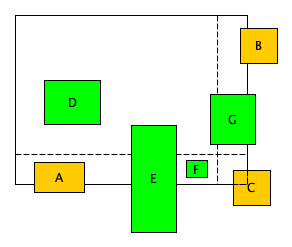

## Tiling a few test images

In [3]:
#TEMPORARY: set paths to "test2" directory
im_src = str('/cdata/tanzania/test2/images') #'./src/images'
an_src = str('/cdata/tanzania/test2/annotations') #'./src/annotations'
im_dst = '/cdata/tanzania/temp/tiled_images'
an_dst = '/cdata/tanzania/temp/tiled_annotations'

In [5]:
#Instantiate the slicer
slicer = ibs.Slicer()
slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst)

In [18]:
#Configure the slicer
slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
slicer.save_before_after_map = True #Writes a csv file with filename/tilenames
slicer.exclude_fragments = False #Excludes bounding box fragments if they are smaller than tile overlap in appropriate direction

#tile_overlap: float (percentage of tile overlap between two consecutive strides).
#Image 2 is (6490, 4510) pixels

In [19]:
#Slice away!
slicer.slice_by_size(tile_size=(500,500), tile_overlap=0.10,empty_sample=0)

Obtained 15 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 15 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images


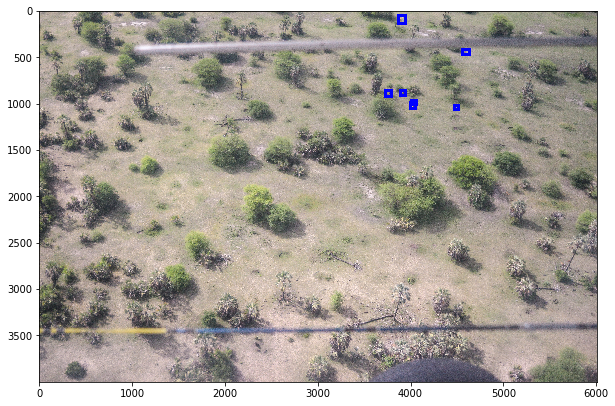

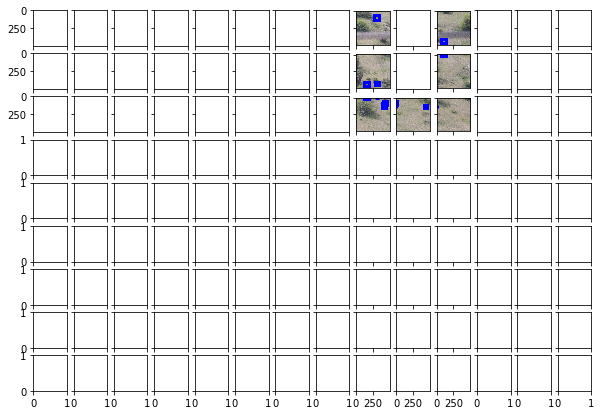

In [20]:
#Pick an image and its tiles at random (BE PATIENT -- the tiled matrix is very slow to render)
slicer.visualize_sliced_random()

Note the many box fragments in the matrix above; it's unlikely that most would contain recognizable objects.

# Factory tiling


In [6]:
#Set main paths (repeated here for convenience when restarting the kernel)
imagepath = Path('/cdata/tanzania/TA25/_data/RKE') #Parent folder for images
annotation_source_path = Path('/cdata/tanzania/TA25') #Where original zipped annotation files are
annotationpath = Path('/cdata/tanzania/temp/annotations') #Destination parent folder for unzipped annotation files (where we want them to go)

In [7]:
#Get Pascal-VOC annotation files (in /TA25 itself)
annotation_files = [str(x) for x in annotation_source_path.iterdir() if str(x).find('pascal') > 0 and x.suffix == '.zip'] #convert strings to Paths and get parent folder
annotation_files

['/cdata/tanzania/TA25/TA25-RKE-20191128A_pascalvoc.zip',
 '/cdata/tanzania/TA25/TA25-RKE-20191202-3_pascalvoc.zip']

In [8]:
#Set up image paths. The destination (where tiles go) is the same for all files; sources change each time.

#Destinations
im_dst = '/cdata/tanzania/temp/tiled_images'
an_dst = '/cdata/tanzania/temp/tiled_annotations'

#Test source with only 2 images
#im_src = '/cdata/tanzania/test2/images' #'./src/images'
#an_src = '/cdata/tanzania/test2/annotations' #'./src/annotations'

#Test source (a single subdirectory with 17 images)
#sub = 'TA25-RKE-20191203B'
#im_src = str(imagepath/sub) 
#an_src = str(annotationpath/sub)

In [15]:
#CALL: TILE ALL IMAGES!!
subdirs = get_subdirs(annotation_files)

for sub in subdirs:
    #Set image and annotation sourcepaths
    im_src = str(imagepath/sub) 
    an_src = str(annotationpath/sub)
    
    #Instantiate the slicer
    slicer = ibs.Slicer()
    slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst)
    
    #Configure the slicer
    slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
    slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
    slicer.save_before_after_map = True #Writes a csv file with filename/tilenames
    slicer.exclude_fragments = True #Excludes bounding box fragments if they are smaller than tile overlap in appropriate direction
    
    #Slice away. Should produce 4 lines of output per subdirectory. 
    slicer.slice_by_size(tile_size=(500,500), tile_overlap=0.20,empty_sample=.005)
    

Obtained 1156 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 1156 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images


/data/home/egdod/jdev/image_bbox_tiler/image_bbox_slicer/helpers.py:114: UserWarning: Destination directory /cdata/tanzania/temp/tiled_images already has some files
  'Destination directory {} already has some files'.format(dir_path))
/data/home/egdod/jdev/image_bbox_tiler/image_bbox_slicer/helpers.py:114: UserWarning: Destination directory /cdata/tanzania/temp/tiled_annotations already has some files
  'Destination directory {} already has some files'.format(dir_path))


Obtained 762 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 762 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images
Obtained 163 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 163 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images
Obtained 158 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 158 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images


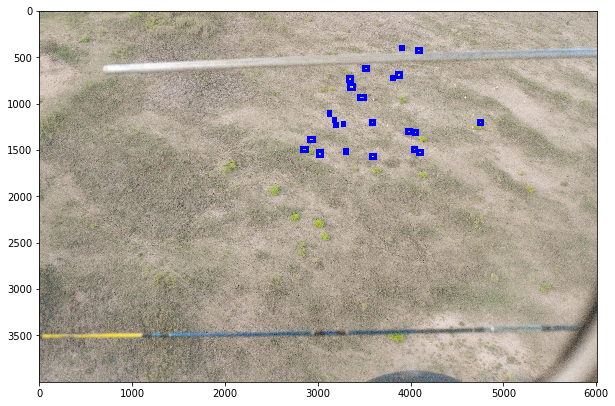

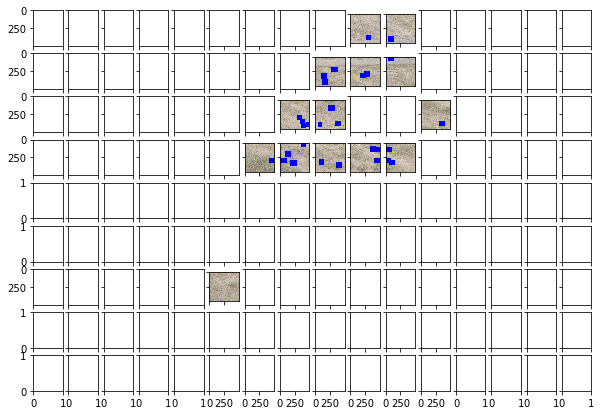

In [16]:
#Note: this will look at the last subdirectory tiled
slicer.visualize_sliced_random()

# Code scraps

## libvips (which has a Python wrapper called pyvips)
**Howard, I'm thinking that we might want to use libvips when we do production tiling, since there won't be any bounding boxes to worry about and it's fast.**
The library is designed for working with very large images without blowing out RAM; it's fast and streamlined.  But libvips does not have a perfect tiling function; instead the author recommends the `dzsave` function, which is designed for making image pyramids for tiled imagery.
The author answered some of my questions on StackExchange: 
1. Tile names are in the form `column_row.tif` if you save to the deepzoom format; 
2. "`dzsave` outputs deepzoom / google maps / zoomify / iiif pyramids, so you get a choice from those naming conventions. 
3. "Overlaps are just pixels that are shared between tiles, so eg. with overlap 1, the rightmost two columns in tile 0_0 are identical to the leftmost two column in tile 1_0. Set overlap to 0 if you want non-overlapping tiles."
https://libvips.github.io/libvips/API/current/Making-image-pyramids.md.html

```bash
vips dzsave hugefile.tif outdir --depth one --tile-size 512 --overlap 0 --suffix .tif
    --depth one #slices a large image into tiles, rather than making a pyramid.
    overlap #Tile overlap in pixels--warning: input parameter 'gint' has a default of 1!
    --background 0 #black
```

Comparing libvips to ImageMagick, libvips seems faster:

In [27]:
# $ time convert -crop 512x512 +repage huge.tif x/image_out_%d.tif
# real    0m5.623s
# user    0m2.060s
# sys     0m2.148s
# $ time vips dzsave huge.tif x --depth one --tile-size 512 --overlap 0 --suffix .tif
# real    0m1.643s
# user    0m1.668s
# sys     0m1.000s

More libvips code examples

In [28]:
# import pyvips

# image = pyvips.Image.new_from_file('some-image.jpg', access='sequential')
# image *= [1, 2, 1]
# mask = pyvips.Image.new_from_array([[-1, -1, -1],
#                                     [-1, 16, -1],
#                                     [-1, -1, -1]
#                                    ], scale=8)
# image = image.conv(mask, precision='integer')
# image.write_to_file('x.jpg')

ImageMagick code for tiling **and renaming tiles by row and column**

In [ ]:
magick hugeimage.png -crop 256x256 -set filename:f "tile_%[fx:page.x],%[fx:page.y]_%[w]x%[h]" "%

...and lastly, **a custom method for reducing the memory impact when using ImageMagick**.

In [ ]:
# #This version puts row and col in the filename (good for reassembly!).  Trick is to divide coordinate by cropsize.  
# #He added 1001 instead of 1 to get constant-width numbers in the output. Nice!
# #!/bin/bash
# /usr/bin/convert bigimage.jpg -crop 256x256 \
#   -set filename:tile "%[fx:page.x/256+1001]_%[fx:page.y/256+1001]" \
#     +repage +adjoin "tiled_%[filename:tile].jpg"
    
# convert -verbose images\0.png -crop 256x256 +adjoin -background white -extent 256x256 -set filename:tile "%%[fx:floor(page.x/256)]_%%[fx:floor(page.y/256)]" +repage "tiles\0_%%[filename:tile].png"

# #OR a 3-step method:
# #1. convert to mpc (ImageMagick's native format)
# convert -monitor -limit area 2mb myLargeImg.tif myLargeImg.mpc
# #2. Bash program (potentially useful anyway)
# #!/bin/bash
#  src=$1
#  width=`identify -format %w $src`
#  limit=$[$width / 256]
#  echo "count = $limit * $limit = "$((limit * limit))" tiles"
#  limit=$((limit-1))
#  for x in `seq 0 $limit`; do
#    for y in `seq 0 $limit`; do
#      tile=tile-$x-$y.png
#      echo -n $tile
#      w=$((x * 256))
#      h=$((y * 256))
#      convert -debug cache -monitor $src -crop 256x256+$w+$h $tile
#    done
#  done

# #3. call the bash program
#  sh ./tiler.sh myLargeImg.mpc
    

# Other random tidbits

In [43]:
#not needed, but could be useful anyway
#Find the image file directories that go with the annotation file
imageroot = Path('/cdata/tanzania/TA25/_data/RKE')/subdirs[0]
annfile_imagepath = imageroot/subdirs[0]
ann_target_folders = [ x for x in annfile_imagepath.glob(subdirs[0]+'*')]
ann_target_folders

[PosixPath('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R'),
 PosixPath('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L')]

In [ ]:
#Not needed but the separate counts for each directory are nice
tot_images = []

for d in range(0,len(ann_target_folders)):
    imgs = None
    imgs = get_image_files(ann_target_folders[d])
    imgs = [str(im) for im in imgs]
    print(str(ann_target_folders[d]),len(imgs),'image files')
    tot_images = tot_images + imgs #Join lists
    
print('Total images: ',len(tot_images))

In [248]:
#Create a little database associating annotation files with annotation subdirectories and image directories.
#Note: most values are Pathlib Paths, not strings.
# def find_target_dirs(imagepath,annotationpath,annotation_files):
#     """
#     Uses the annotation filename to set a target directory for unzipping annotation files and
#     to determine the parent directory for the corresponding images.  Returns a little database.
#     """
#     records = []
#     #Get subdirectories from the annotation file names (take the stem and drop "_pascalvoc")
#     subdir_dict = get_subdir_dict(annotation_files)
#     for f in annotation_files:
#         #find the subdirectory in the filename and set it as the destination for unzipped files
#         for sub in subdir_dict[f]:
#             dest = Path('/cdata/tanzania/temp/annotations')/sub
#             target_image_dir = imagepath/sub
#             records.append([f,sub,dest,target_image_dir])            
#     ann_db = pd.DataFrame(records, columns=['ann_sourcefile', 'subdirectory','ann_dest_dir','target_image_dir'])
#     return (ann_db)